<a href="https://colab.research.google.com/github/armen1s/BOT/blob/main/CatB_Test4_Iter_25_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python3 --version

Python 3.10.12


In [ ]:
#@title Установка Python 3.10.13 и конкретных версий библиотек

# 1. Установка Python 3.10.13
!sudo apt-get update -y
!sudo apt-get install -y python3.10 python3.10-distutils
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!sudo update-alternatives --set python3 /usr/bin/python3.10
!python3 --version

# 2. Установка pip для Python 3.10.13
!curl -sS https://bootstrap.pypa.io/get-pip.py | python3
!python3 -m pip install --upgrade pip

# 3. Установка нужных версий библиотек через pip
!python3 -m pip install \
    "pybit~=5.6.2" \
    "pandas~=2.2.2" \
    "pykalman~=0.9.7" \
    "scipy~=1.14.0" \
    "numpy==1.24.3" \
    "scikit-learn==1.6.1" \
    "joblib==1.4.2"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,747 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,561 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,0

In [2]:
#@title Install libs
!pip install catboost
!pip install ccxt

"""
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
"""

!pip install TA-Lib-Precompiled
!pip install numpy==1.24.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.0/628.0 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 66.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.3 which is incompatible.
pymc 5.23.0 requires numpy>=1

In [1]:
from logging import warning
#@title Load libs
import numpy as np

# Data Management
import pandas as pd

# Machine Learning
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

# ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

#Sampling Methods
from imblearn.over_sampling import ADASYN

#Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Binary Classification Specific Metrics
from sklearn.metrics import RocCurveDisplay as plot_roc_curve

# General Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import ConfusionMatrixDisplay


# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree

from hyperopt import fmin, tpe, hp
from pandas_datareader.data import DataReader

import json
from datetime import datetime
import talib as ta
import ccxt

import matplotlib.pyplot as plt

from tqdm import tqdm
import pickle as pk
import joblib

#Functions

In [2]:
import numpy as np
import pandas as pd
import talib as ta


def get_indicators(data, timeframes, volatility_look_back, supertrend_multiplier=3):
    """
    Возвращает датафрейм с индикаторами:
        – классические (ATR, RSI, VWAP, Supertrend …)
        – «нишумовые» фичи для распознавания нулевого класса
    """
    df = data.copy()

    # ----------------------------------------------------------
    for timeframe in timeframes:
        # --- базовые индикаторы
        df[f'ATR_{timeframe}']  = ta.ATR(df['high'], df['low'], df['close'], timeperiod=timeframe)
        df[f'RSI_{timeframe}']  = ta.RSI(df['close'], timeperiod=timeframe)


        df[f'CCI_{timeframe}']  = ta.CCI(df['high'], df['low'], df['close'], timeperiod=timeframe)

        # --- DPO
        offset = timeframe // 2 + 1
        sma    = df['close'].rolling(window=timeframe).mean()
        df[f'DPO_{timeframe}'] = df['close'].shift(offset) - sma
        dpo_range = df[f'DPO_{timeframe}'].rolling(window=timeframe).apply(lambda x: x.max() - x.min())
        df[f'DPO_flat_{timeframe}'] = (dpo_range < 0.01).astype(int)




        # --- Supertrend
        hl2 = (df['high'] + df['low']) / 2
        atr = ta.ATR(df['high'], df['low'], df['close'], timeperiod=timeframe)
        upper_band = hl2 + supertrend_multiplier * atr
        lower_band = hl2 - supertrend_multiplier * atr

        supertrend = [np.nan] * len(df)
        in_uptrend = [True] * len(df)

        for i in range(timeframe, len(df)):
            close_i   = df['close'].iloc[i]

            if close_i > upper_band.iloc[i - 1]:
                in_uptrend[i] = True
            elif close_i < lower_band.iloc[i - 1]:
                in_uptrend[i] = False
            else:
                in_uptrend[i] = in_uptrend[i - 1]
                if in_uptrend[i] and lower_band.iloc[i] < lower_band.iloc[i - 1]:
                    lower_band.iloc[i] = lower_band.iloc[i - 1]
                if not in_uptrend[i] and upper_band.iloc[i] > upper_band.iloc[i - 1]:
                    upper_band.iloc[i] = upper_band.iloc[i - 1]

            supertrend[i] = lower_band.iloc[i] if in_uptrend[i] else upper_band.iloc[i]

        df[f'Supertrend_{timeframe}']        = supertrend
        df[f'Supertrend_trend_{timeframe}']  = in_uptrend

        # ------------------------------------------------------
        # ❷ «Тишинные» фичи для нулевого класса
        # ------------------------------------------------------
        # амплитуда и тело свечи
        df['range_abs']   = df['high'] - df['low']
        df['candle_body'] = (df['open'] - df['close']).abs()





    # ----------------------------------------------------------
    # ❸ Глобальные метрики
    # ----------------------------------------------------------
    df["returns"]    = (df["close"] / df["close"].shift(volatility_look_back)) - 1
    df["range"]      = (df["high"] / df["low"]) - 1
    df["volatility"] = df["returns"].rolling(window=volatility_look_back).std(ddof=0)

    # Volume‑based
    df['ADL'] = ta.AD(df['high'], df['low'], df['close'], df['volume'])
    df['ROC'] = ta.ROC(df['close'], timeperiod=volatility_look_back)


    # Momentum
    slowk, _ = ta.STOCH(df['high'], df['low'], df['close'])
    df['Stoch_Oscillator'] = slowk
    df['PSAR'] = ta.SAR(df['high'], df['low'], acceleration=0.02, maximum=0.2)
    df['ADX']  = ta.ADX(df['high'], df['low'], df['close'], timeperiod=volatility_look_back)

    return df

In [3]:
#@title New Mark Function
def get_shifts(df, K=4): #(data, K=4):
    #df=data.copy()
    for i in range(K):
        name_back=f'shift_{i}'
        name_frorward=f'shift_-{i}'
        df[name_back]=df['close'].shift(i)
        df[name_frorward]=df['close'].shift(-i)
    df.dropna(inplace=True)
    #return df

def get_coefs(df, K=4): #data, K=4):
    #df=data.copy()

    #get means
    back_col_names=[f'shift_{i}' for i in range(K)]
    frorward_col_names=[f'shift_-{i}' for i in range(K)]
    back_result=[i.mean() for i in df[back_col_names].values]
    frorward_result=[i.mean() for i in df[frorward_col_names].values]
    df['mean_back']=back_result
    df['mean_frorward']=frorward_result

    #get coefs
    df['coef']=(df['mean_frorward']-df['mean_back'])/df['mean_back']
    #return df

def get_classes(df,std_corrector=1): #data, std_corrector=1):
    #df=data.copy()
    long_thold=df['coef'][df['coef']>=0].mean()-df['coef'][df['coef']>=0].std()/std_corrector
    short_thold=df['coef'][df['coef']<0].mean()+df['coef'][df['coef']<0].std()/std_corrector
    df['target']=0
    df['target'][df['coef']>long_thold]=1
    df['target'][df['coef']<short_thold]=2 #-1
    #return df

def get_lbls(data, K=4, std_corrector=1):
    df=data.copy()
    get_shifts(df, K)
    get_coefs(df, K)
    get_classes(df, std_corrector)

    return df

In [9]:
#@title Indicators adding function
def add_indicators(data,
                   timeframes = [2, 4, 6, 7, 8, 9, 10, 12, 14, 16, 18, 22, 30 ],
                   volatility_look_back= 2):
    df_w_indicators=get_indicators(data,
                               timeframes,
                               volatility_look_back)
    df_w_indicators.dropna(inplace=True)

    # Apply np.isinf and np.isnan to numerical columns only
    numerical_cols = df_w_indicators.select_dtypes(include=np.number).columns
    # Recalculate inf_mask using df_cleaned instead of df_w_indicators
    inf_mask = np.isinf(df_w_indicators[numerical_cols]) | np.isnan(df_w_indicators[numerical_cols])

    # Update the rest of the code accordingly
    df_cleaned = df_w_indicators[~inf_mask.any(axis=1)]
    # Use numerical_cols for column selection to ensure alignment
    df = df_cleaned.loc[:, numerical_cols[~inf_mask.any(axis=0)]]
    df.dropna(inplace=True)
    return df

#Data preparation

In [10]:
#@title Read csv
five_min_df = pd.read_csv('/content/5m_2025-04-29_2025-06-21_bybit_btcusdt_ohlcv.csv')

# Удаляем строки, где timestamp равен '2' (или содержит некорректные данные)
five_min_df = five_min_df[five_min_df['timestamp'] != '2']

# Удаляем строки с пустым volume
five_min_df = five_min_df.dropna(subset=['volume'])

# Преобразуем столбец 'timestamp' в datetime
five_min_df['timestamp'] = pd.to_datetime(five_min_df['timestamp'])

# Устанавливаем столбец 'timestamp' в качестве индекса
five_min_df.set_index('timestamp', inplace=True)



print(f"Исходный размер DataFrame: {len(five_min_df)}")

Исходный размер DataFrame: 15265


In [11]:
#@title Primary split
train_splitter=round(len(five_min_df)*0.7)
train=five_min_df.iloc[:train_splitter]


val_splitter=round(len(five_min_df)*0.85)
val=five_min_df.iloc[:val_splitter]

test=five_min_df.copy()

In [12]:
#@title Adding indicators to train/test/val
train_w_ind=add_indicators(train)
val_w_ind=add_indicators(val)
test_w_ind=add_indicators(test)

/tmp/ipython-input-2-944347872.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PSAR'] = ta.SAR(df['high'], df['low'], acceleration=0.02, maximum=0.2)
/tmp/ipython-input-2-944347872.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ADX']  = ta.ADX(df['high'], df['low'], df['close'], timeperiod=volatility_look_back)
/tmp/ipython-input-2-944347872.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

In [13]:
#@title Add target (New)

STD_CORRECTOR = 2 #@param {type: "integer"}
K = 4 #@param {type: "integer"}

train_input=get_lbls(train_w_ind, K=K, std_corrector=STD_CORRECTOR)
val_input=get_lbls(val_w_ind, K=K, std_corrector=STD_CORRECTOR)
test_input=get_lbls(test_w_ind, K=K, std_corrector=STD_CORRECTOR)
train_input=train_input.reset_index()
val_input=val_input.reset_index()
test_input=test_input.reset_index()

drop_cols=[f'shift_-{i}' for i in range(K)]
#drop_cols.append('mean_frorward')
test_input=test_input.drop(columns=drop_cols)
val_input=val_input.drop(columns=drop_cols)
train_input=train_input.drop(columns=drop_cols)


#keys=list(train_input.keys())
#keys.append('target')
#df.head()
#df['target'].hist()

/tmp/ipython-input-3-450657997.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['target'][df['coef']>long_thold]=1
/tmp/ipython-input-3-450657997.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

<Axes: >

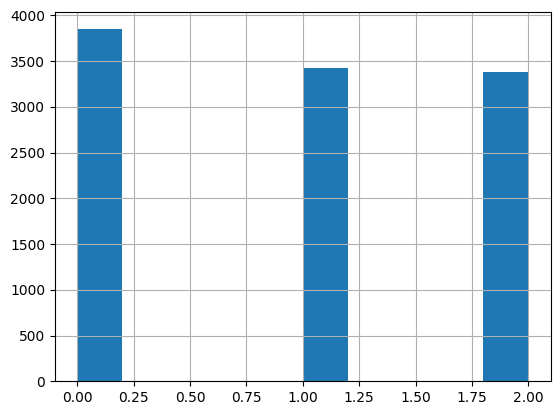

In [14]:
#@title Look at class balance
train_input['target'].hist()

#Train

In [15]:
#@title StandardScaler + Final split
scaler = StandardScaler()

train_target=train_input.iloc[:, -1].copy()
train_input=train_input.iloc[:,1 : -3].copy() # -3 to exclude coef and mean_forward
feature_namess= train_input.columns
train_input=scaler.fit_transform(train_input)

val_target=val_input.iloc[:, -1].copy()
val_input=val_input.iloc[:,1 : -3].copy()
val_input=scaler.transform(val_input)
val_target=val_target.iloc[train_splitter:]
val_input=val_input[train_splitter:]

test_target=test_input.iloc[:, -1].copy()
test_input=test_input.iloc[:,1 : -3].copy()
test_input=scaler.transform(test_input)
test_target=test_target.iloc[val_splitter:]
test_input=test_input[val_splitter:]

In [ ]:
#@title Set models and Run train
rf_classifier = RandomForestClassifier(
    n_estimators=20,
    max_depth=4,
    max_features = None
    min_samples_split = 3
    min_samples_leaf = 2
    class_weight={0: 2, 1: 3, 2: 3},  # приоритет: 0 ≫ 2 ≫ 1
    n_jobs=-1,
    random_state=42,
    bootstrap = True,
)

gb_classifier = GradientBoostingClassifier(
    n_estimators=840,
    learning_rate=0.1,
    subsample=0.8,
    max_depth=6,
    random_state=42
    # классические sklearn модели не имеют параметра class_weight — передадим ниже
)

catboost_classifier = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.07,
    depth=8,
    l2_leaf_reg=3,
    border_count=128,
    rsm = 0.9,
    bagging_temperature=0.7,
    random_strength=0.5,
    boosting_type='Ordered',
    leaf_estimation_iterations=10,
    leaf_estimation_method='Newton',
    class_weights=[ 3, 6, 7],  # порядок: [0, 1, 2]
    verbose=0,
    random_state=42,
)

classifiers = [('Random Forest', rf_classifier),
               ('Gradient Boosting', gb_classifier),
               ('CatBoost', catboost_classifier)]

voting_classifier = VotingClassifier(estimators=classifiers, voting='soft')

# если ты хочешь, чтобы веса работали и в GradientBoostingClassifier, — добавь:
from sklearn.utils.class_weight import compute_sample_weight
sample_w = compute_sample_weight(class_weight={0: 3, 1: 6, 2: 7}, y=train_target)

# Train the VotingClassifier on the training data
voting_classifier.fit(train_input, train_target, sample_weight=sample_w)

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(bootstrap=False,
                                                     class_weight={0: 3, 1: 6,
                                                                   2: 7},
                                                     n_estimators=300,
                                                     n_jobs=-1,
                                                     random_state=42)),
                             ('Gradient Boosting',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=6,
                                                         n_estimators=300,
                                                         random_state=42,
                                                         subsample=0.8)),
                             ('CatBoost',
                              <catboost.core.CatBoostClassifier object at 0x7ba0b9891250>)],
                 voting='soft')

Ensemble Accuracy: 0.5946305746616375
Classification Report (Entire Dataset):
              precision    recall  f1-score   support

           0       0.62      0.41      0.49      1705
           1       0.60      0.68      0.64      1370
           2       0.58      0.74      0.65      1432

    accuracy                           0.59      4507
   macro avg       0.60      0.61      0.59      4507
weighted avg       0.60      0.59      0.58      4507

Confusion Matrix (Entire Dataset):
[[ 697  442  566]
 [ 232  925  213]
 [ 200  174 1058]]
Confusion Matrix - Entire Dataset:


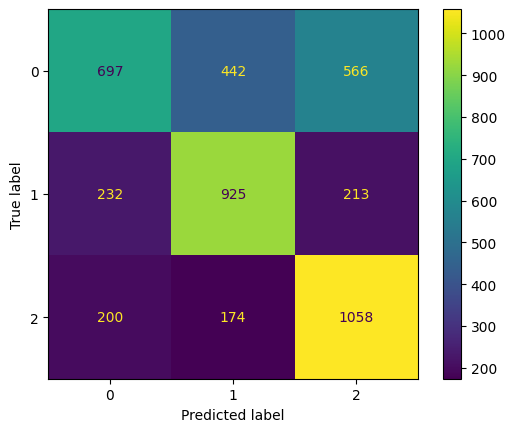

In [ ]:
#@title Test (new) (StandartSclaer)
pred_target = voting_classifier.predict(np.vstack((val_input,test_input)))
accuracy = accuracy_score(np.hstack((val_target.values, test_target.values)), pred_target)
print("Ensemble Accuracy:", accuracy)


print("Classification Report (Entire Dataset):")
print(classification_report(np.hstack((val_target.values, test_target.values)), pred_target))
print("Confusion Matrix (Entire Dataset):")
print(confusion_matrix(np.hstack((val_target.values, test_target.values)), pred_target))
cm_target = confusion_matrix(np.hstack((val_target.values, test_target.values)), pred_target)
print("Confusion Matrix - Entire Dataset:")
ConfusionMatrixDisplay(cm_target).plot()

In [ ]:
#@title Save VC
joblib.dump(voting_classifier, 'voting_classifier_11042025.pkl')

['voting_classifier_11042025.pkl']

In [ ]:
#@title 🔍 Проверка версии joblib
import joblib
print("joblib version:", joblib.__version__)

joblib version: 1.5.1


#Spliting test array to test1 as val and test2 as main test. Using val to search right confidence

In [ ]:
predicted_classes = voting_classifier.predict(val_input)
predicted_probs = voting_classifier.predict_proba(val_input)

n_classes = predicted_probs.shape[1]
results_df = pd.DataFrame(predicted_probs, columns=[f'prob_class_{i}' for i in range(n_classes)])

# Добавляем истинные и предсказанные метки
results_df['true_target'] = val_target.values
results_df['predicted_target'] = predicted_classes

# Вычисляем уверенность: максимальное значение вероятности для каждого примера
results_df['confidence'] = predicted_probs.max(axis=1)

# Флаг: предсказание правильное или нет
results_df['correct'] = results_df['true_target'] == results_df['predicted_target']

# Вычисляем соотношение между максимальной и второй по величине вероятностью
# Сначала сортируем вероятности по каждой строке
sorted_probs = np.sort(predicted_probs, axis=1)
# Последний столбец — максимальное значение, предпоследний — второй максимум.
results_df['ratio_max_second'] = sorted_probs[:, -1] / sorted_probs[:, -2]

print(results_df.head())

   prob_class_0  prob_class_1  prob_class_2  true_target  predicted_target  \
0      0.301987      0.024391      0.673622            2                 2   
1      0.432826      0.034265      0.532910            2                 2   
2      0.130409      0.018759      0.850831            2                 2   
3      0.098059      0.014948      0.886993            2                 2   
4      0.210683      0.020061      0.769256            2                 2   

   confidence  correct  ratio_max_second  
0    0.673622     True          2.230633  
1    0.532910     True          1.231233  
2    0.850831     True          6.524304  
3    0.886993     True          9.045495  
4    0.769256     True          3.651246  


In [ ]:
# Средняя уверенность
mean_confidence_correct = results_df[results_df['correct']]['confidence'].mean()
mean_confidence_wrong = results_df[~results_df['correct']]['confidence'].mean()

print("Средняя уверенность на верных предсказаниях:", mean_confidence_correct)
print("Средняя уверенность на ошибочных предсказаниях:", mean_confidence_wrong)

# Среднее соотношение вероятностей (макс/второй максимум)
mean_ratio_correct = results_df[results_df['correct']]['ratio_max_second'].mean()
mean_ratio_wrong = results_df[~results_df['correct']]['ratio_max_second'].mean()

print("Среднее соотношение (макс/второй максимум) на верных предсказаниях:", mean_ratio_correct)
print("Среднее соотношение (макс/второй максимум) на ошибочных предсказаниях:", mean_ratio_wrong)

Средняя уверенность на верных предсказаниях: 0.6651995354433126
Средняя уверенность на ошибочных предсказаниях: 0.5742031329921587
Среднее соотношение (макс/второй максимум) на верных предсказаниях: 5.339428511591869
Среднее соотношение (макс/второй максимум) на ошибочных предсказаниях: 2.484652549045935


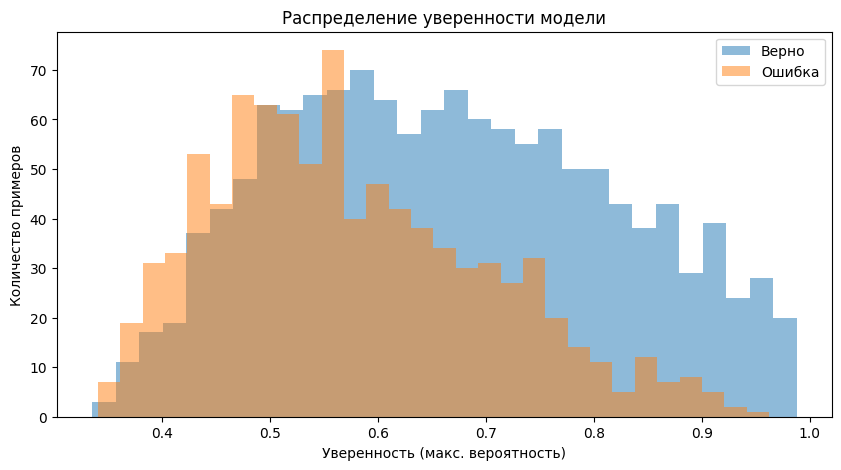

In [ ]:
plt.figure(figsize=(10, 5))

# Гистограмма для верных предсказаний
plt.hist(results_df[results_df['correct']]['confidence'], bins=30, alpha=0.5, label='Верно')

# Гистограмма для ошибочных предсказаний
plt.hist(results_df[~results_df['correct']]['confidence'], bins=30, alpha=0.5, label='Ошибка')

plt.xlabel('Уверенность (макс. вероятность)')
plt.ylabel('Количество примеров')
plt.title('Распределение уверенности модели')
plt.legend()
plt.show()

In [ ]:
# --- Расчет соотношения верных ответов к ошибочным при confidence > 0.68 ---

# 1. Фильтруем предсказания, где уверенность модели больше 0.68
high_confidence_df = results_df[results_df['confidence'] > 0.65]

# Проверяем, есть ли вообще такие предсказания
if not high_confidence_df.empty:
    # 2. Считаем количество верных и ошибочных ответов в отфильтрованной группе
    # Для boolean колонки .sum() эффективно считает количество True
    correct_count = high_confidence_df['correct'].sum()

    # Общее количество минус верные = ошибочные
    wrong_count = len(high_confidence_df) - correct_count

    # 3. Выводим подробную статистику
    print(f"Анализ предсказаний с уверенностью > 68%:")
    print(f"  Всего таких предсказаний: {len(high_confidence_df)}")
    print(f"  Из них верных: {correct_count}")
    print(f"  Из них ошибочных: {wrong_count}")

    # 4. Рассчитываем и выводим итоговое соотношение
    # Проверяем, есть ли ошибочные ответы, чтобы избежать деления на ноль
    if wrong_count > 0:
        ratio_correct_to_wrong = correct_count / wrong_count
        print(f"\nСоотношение верных к ошибочным = {ratio_correct_to_wrong:.2f} к 1")
    else:
        # Если ошибок нет, соотношение стремится к бесконечности
        print("\nОшибочных предсказаний в этой группе нет.")

else:
    # Если предсказаний с такой уверенностью не нашлось
    print("Предсказаний с уверенностью > 0.68 не найдено.")

Анализ предсказаний с уверенностью > 68%:
  Всего таких предсказаний: 929
  Из них верных: 687
  Из них ошибочных: 242

Соотношение верных к ошибочным = 2.84 к 1


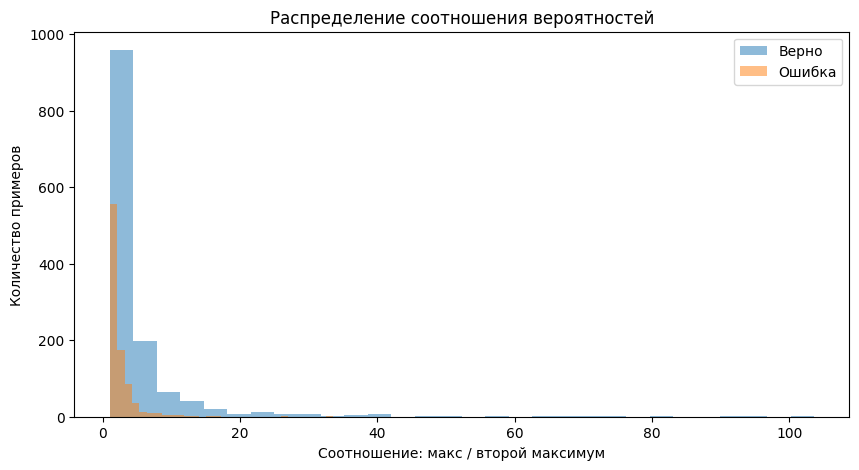

In [ ]:
plt.figure(figsize=(10, 5))

plt.hist(results_df[results_df['correct']]['ratio_max_second'], bins=30, alpha=0.5, label='Верно')
plt.hist(results_df[~results_df['correct']]['ratio_max_second'], bins=30, alpha=0.5, label='Ошибка')

plt.xlabel('Соотношение: макс / второй максимум')
plt.ylabel('Количество примеров')
plt.title('Распределение соотношения вероятностей')
plt.legend()
plt.show()

#Using test with val confidence to predict classes 1 and 2

In [ ]:
predicted_classes2 = voting_classifier.predict(test_input)
predicted_probs2 = voting_classifier.predict_proba(test_input)

n_classes = predicted_probs2.shape[1]
results_df2 = pd.DataFrame(predicted_probs2, columns=[f'prob_class_{i}' for i in range(n_classes)])

# Добавляем истинные и предсказанные метки
results_df2['true_target'] = test_target.values
results_df2['predicted_target'] = predicted_classes2

# Вычисляем уверенность: максимальное значение вероятности для каждого примера
results_df2['confidence'] = predicted_probs2.max(axis=1)

# Флаг: предсказание правильное или нет
results_df2['correct'] = results_df2['true_target'] == results_df2['predicted_target']

sorted_probs = np.sort(predicted_probs2, axis=1)
# Последний столбец — максимальное значение, предпоследний — второй максимум.
results_df2['ratio_max_second'] = sorted_probs[:, -1] / sorted_probs[:, -2]

print(results_df2.head())

   prob_class_0  prob_class_1  prob_class_2  true_target  predicted_target  \
0      0.275975      0.101878      0.622147            2                 2   
1      0.151176      0.054389      0.794435            2                 2   
2      0.189073      0.204026      0.606901            2                 2   
3      0.302151      0.212157      0.485692            0                 2   
4      0.222425      0.154997      0.622578            1                 2   

   confidence  correct  ratio_max_second  
0    0.622147     True          2.254355  
1    0.794435     True          5.255042  
2    0.606901     True          2.974635  
3    0.485692    False          1.607449  
4    0.622578    False          2.799047  


In [ ]:
filtered_df = results_df2[(results_df2['true_target'].isin([1, 2])) & (results_df2['confidence'] > mean_confidence_correct)]
accuracy_filtered = filtered_df['correct'].mean()

print('Всего наблюдений в второй части тестовой выборки: '+str(len(np.vstack((val_input,test_input)))))
print('Всего меток 1 и 2 проставлено моделью: '+str(len(results_df2[(results_df2['true_target'].isin([1, 2]))])))
print('Всего меток, проставленных моделью, осталось после фильтрации: '+str(len(filtered_df)))
print()
print(f"Точность для классов 1 и 2 при уверенности > {mean_confidence_correct}:", accuracy_filtered)

Всего наблюдений в второй части тестовой выборки: 4507
Всего меток 1 и 2 проставлено моделью: 1405
Всего меток, проставленных моделью, осталось после фильтрации: 695

Точность для классов 1 и 2 при уверенности > 0.6651995354433126: 0.9165467625899281


In [ ]:
%whos DataFrame

Variable      Type         Data/Info
------------------------------------
filtered_df   DataFrame          prob_class_0  prob_<...>n\n[430 rows x 8 columns]
five_min_df   DataFrame                             <...>\n[9000 rows x 5 columns]
results_df    DataFrame          prob_class_0  prob_<...>\n[1314 rows x 8 columns]
results_df2   DataFrame          prob_class_0  prob_<...>\n[1314 rows x 8 columns]
test          DataFrame                             <...>\n[9000 rows x 5 columns]
test_w_ind    DataFrame                             <...>n[8970 rows x 93 columns]
train         DataFrame                             <...>\n[6300 rows x 5 columns]
train_w_ind   DataFrame                             <...>n[6270 rows x 93 columns]
val           DataFrame                             <...>\n[7650 rows x 5 columns]
val_w_ind     DataFrame                             <...>n[7620 rows x 93 columns]


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Примерное время одного прогона модели: 11.77 секунд
Лучшие найденные параметры:  {'bootstrap': True, 'class_weight': {0: 2, 1: 3, 2: 3}, 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 20}
Лучшая точность:  0.5876056338028168

Точность лучшего RandomForestClassifier на объединенном валидационном и тестовом наборе: 0.5924118038606612

Отчет о классификации (Лучший RandomForestClassifier):
              precision    recall  f1-score   support

           0       0.60      0.40      0.48      1705
           1       0.59      0.69      0.64      1370
           2       0.59      0.72      0.65      1432

    accuracy                           0.59      4507
   macro avg       0.59      0.61      0.59      4507
weighted avg       0.59      0.59      0.58      4507


Матрица ошибок (Лучший RandomForestClassifier):


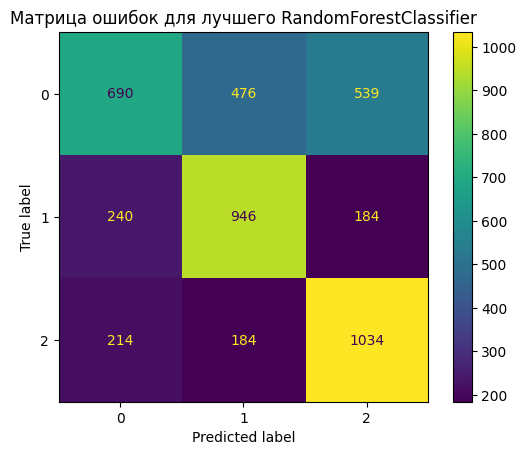

In [ ]:

#@title GridSearchCV для RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
import time

# Определение сетки параметров
param_grid = {
    'n_estimators': [20],
    'max_depth': [4],
    'min_samples_split': [3],
    'min_samples_leaf': [2],
    'bootstrap': [True],
    'max_features':[None],
    'class_weight': [{0: 2, 1: 3, 2: 3}],

}

# Инициализация RandomForestClassifier
rf_grid = RandomForestClassifier(random_state=42)

# Инициализация GridSearchCV
# cv=3 означает 3-кратную кросс-валидацию
# n_jobs=-1 использует все доступные ядра процессора
grid_search = GridSearchCV(estimator=rf_grid, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring=make_scorer(accuracy_score))

# Измерение времени обучения
start_time = time.time()
grid_search.fit(train_input, train_target)
end_time = time.time()

# Расчет и вывод продолжительности одного прогона модели
total_fits = len(grid_search.cv_results_['params']) * 3 # 3 - количество фолдов кросс-валидации
single_fit_duration = (end_time - start_time) / total_fits
print(f"Примерное время одного прогона модели: {single_fit_duration:.2f} секунд")


# Вывод лучших параметров и лучшего результата
print("Лучшие найденные параметры: ", grid_search.best_params_)
print("Лучшая точность: ", grid_search.best_score_)

# Оценка лучшей модели на тестовом наборе
best_rf = grid_search.best_estimator_
pred_target_rf = best_rf.predict(np.vstack((val_input,test_input)))
accuracy_rf = accuracy_score(np.hstack((val_target.values, test_target.values)), pred_target_rf)

print("\nТочность лучшего RandomForestClassifier на объединенном валидационном и тестовом наборе:", accuracy_rf)
print("\nОтчет о классификации (Лучший RandomForestClassifier):")
print(classification_report(np.hstack((val_target.values, test_target.values)), pred_target_rf))
print("\nМатрица ошибок (Лучший RandomForestClassifier):")
cm_rf = confusion_matrix(np.hstack((val_target.values, test_target.values)), pred_target_rf)
ConfusionMatrixDisplay(cm_rf).plot()
plt.title("Матрица ошибок для лучшего RandomForestClassifier")
plt.show()

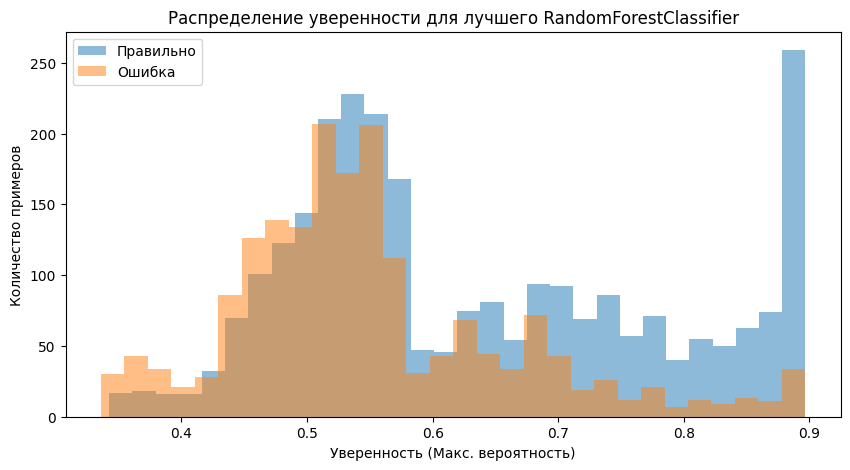

In [ ]:
#@title Распределение правильных и неправильных ответов для лучшего RandomForestClassifier

# Получение предсказаний и вероятностей от лучшей модели RandomForest
predicted_classes_best_rf = best_rf.predict(np.vstack((val_input,test_input)))
predicted_probs_best_rf = best_rf.predict_proba(np.vstack((val_input,test_input)))

# Создание DataFrame для анализа
n_classes_rf = predicted_probs_best_rf.shape[1]
results_df_rf = pd.DataFrame(predicted_probs_best_rf, columns=[f'prob_class_{i}' for i in range(n_classes_rf)])
results_df_rf['true_target'] = np.hstack((val_target.values, test_target.values))
results_df_rf['predicted_target'] = predicted_classes_best_rf
results_df_rf['confidence'] = predicted_probs_best_rf.max(axis=1)
results_df_rf['correct'] = results_df_rf['true_target'] == results_df_rf['predicted_target']

# Построение гистограммы распределения уверенности
plt.figure(figsize=(10, 5))
plt.hist(results_df_rf[results_df_rf['correct']]['confidence'], bins=30, alpha=0.5, label='Правильно')
plt.hist(results_df_rf[~results_df_rf['correct']]['confidence'], bins=30, alpha=0.5, label='Ошибка')
plt.xlabel('Уверенность (Макс. вероятность)')
plt.ylabel('Количество примеров')
plt.title('Распределение уверенности для лучшего RandomForestClassifier')
plt.legend()
plt.show()

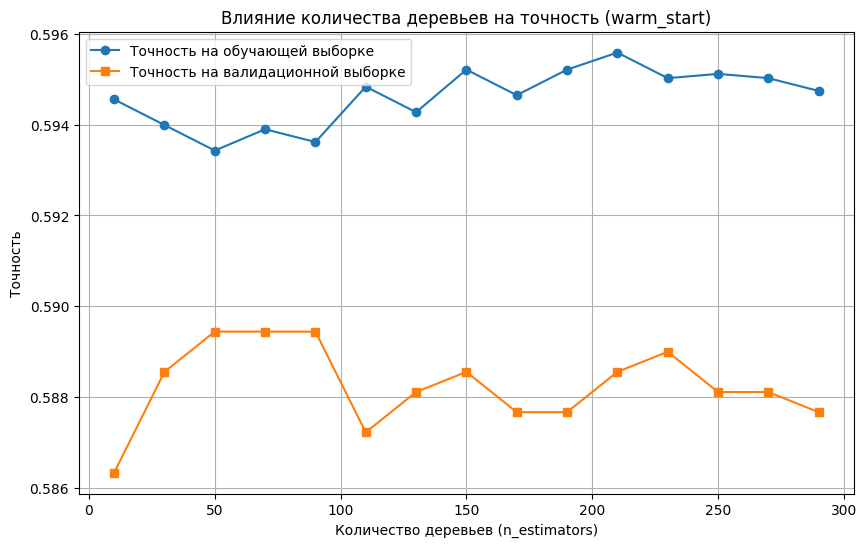

In [ ]:
#@title Анализ влияния n_estimators с использованием warm_start

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

train_scores = []
val_scores = []
n_estimators_range = list(range(10, 310, 20))  # от 10 до 300 деревьев с шагом 20

rf_warm = RandomForestClassifier(
    warm_start=True,
    oob_score=False, # можно включить, если bootstrap=True и нужен out-of-bag
    random_state=42,
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    bootstrap=grid_search.best_params_['bootstrap'],
    max_features=grid_search.best_params_['max_features'],
    class_weight=grid_search.best_params_['class_weight']
)

for n in n_estimators_range:
    rf_warm.set_params(n_estimators=n)
    rf_warm.fit(train_input, train_target)

    train_pred = rf_warm.predict(train_input)
    val_pred = rf_warm.predict(val_input)

    train_scores.append(accuracy_score(train_target, train_pred))
    val_scores.append(accuracy_score(val_target, val_pred))

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_scores, label='Точность на обучающей выборке', marker='o')
plt.plot(n_estimators_range, val_scores, label='Точность на валидационной выборке', marker='s')
plt.xlabel('Количество деревьев (n_estimators)')
plt.ylabel('Точность')
plt.title('Влияние количества деревьев на точность (warm_start)')
plt.legend()
plt.grid(True)
plt.show()

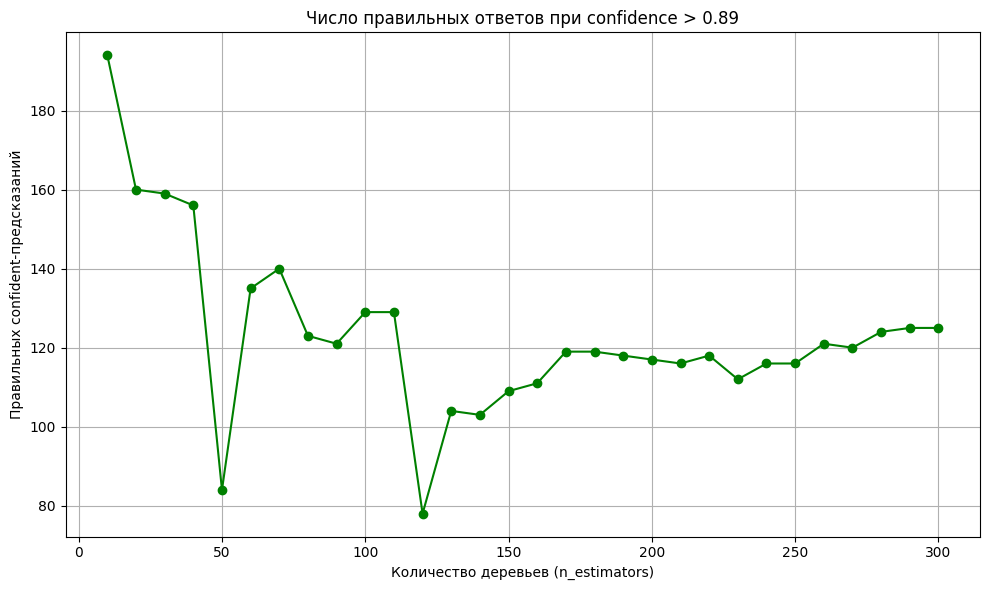

In [ ]:
#@title График количества правильных ответов при confidence > 0.69 в зависимости от n_estimators
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

threshold = 0.89
n_range = range(10, 301, 10)
correct_high_conf_list = []

# Инициализация классификатора с warm_start
rf = RandomForestClassifier(
    warm_start=True,
    random_state=42,
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    bootstrap=grid_search.best_params_['bootstrap'],
    max_features=grid_search.best_params_['max_features'],
    class_weight=grid_search.best_params_['class_weight']
)

# Объединённые входы и цели
X_full = np.vstack((val_input, test_input))
y_full = np.hstack((val_target.values, test_target.values))

# Обучение с постепенным добавлением деревьев
for n in n_range:
    rf.set_params(n_estimators=n)
    rf.fit(train_input, train_target)

    predicted_probs = rf.predict_proba(X_full)
    predicted_classes = rf.predict(X_full)
    confidence = predicted_probs.max(axis=1)
    correct = predicted_classes == y_full

    high_conf_mask = confidence > threshold
    correct_high_conf = np.sum(correct[high_conf_mask])

    correct_high_conf_list.append(correct_high_conf)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(n_range, correct_high_conf_list, marker='o', linestyle='-', color='green')
plt.title(f'Число правильных ответов при confidence > {threshold}')
plt.xlabel('Количество деревьев (n_estimators)')
plt.ylabel('Правильных confident-предсказаний')
plt.grid(True)
plt.tight_layout()
plt.show()

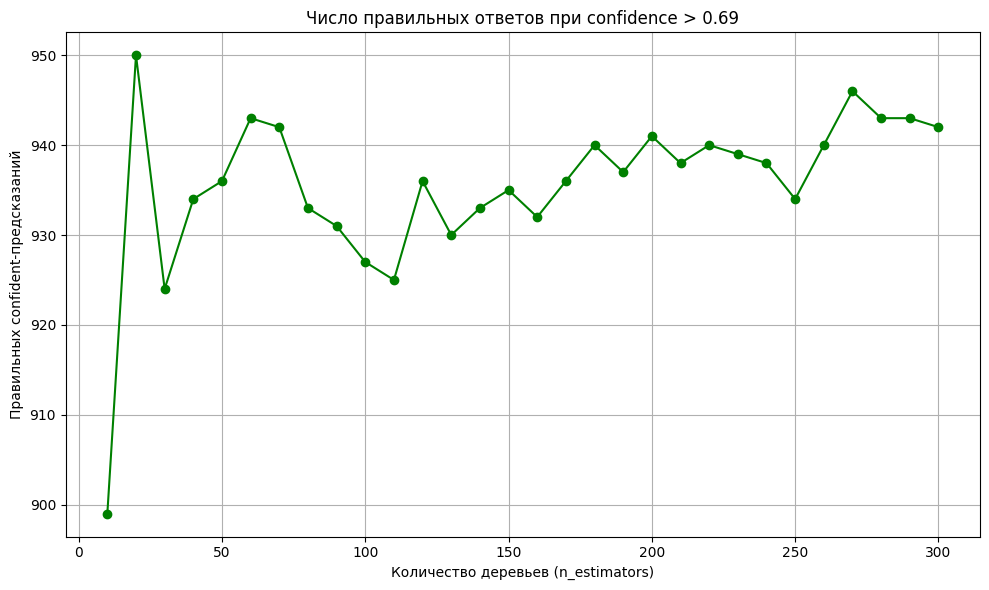

In [ ]:
#@title График количества правильных ответов при confidence > 0.69 в зависимости от n_estimators
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

threshold = 0.69
n_range = range(10, 301, 10)
correct_high_conf_list = []

# Инициализация классификатора с warm_start
rf = RandomForestClassifier(
    warm_start=True,
    random_state=42,
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    bootstrap=grid_search.best_params_['bootstrap'],
    max_features=grid_search.best_params_['max_features'],
    class_weight=grid_search.best_params_['class_weight']
)

# Объединённые входы и цели
X_full = np.vstack((val_input, test_input))
y_full = np.hstack((val_target.values, test_target.values))

# Обучение с постепенным добавлением деревьев
for n in n_range:
    rf.set_params(n_estimators=n)
    rf.fit(train_input, train_target)

    predicted_probs = rf.predict_proba(X_full)
    predicted_classes = rf.predict(X_full)
    confidence = predicted_probs.max(axis=1)
    correct = predicted_classes == y_full

    high_conf_mask = confidence > threshold
    correct_high_conf = np.sum(correct[high_conf_mask])

    correct_high_conf_list.append(correct_high_conf)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(n_range, correct_high_conf_list, marker='o', linestyle='-', color='green')
plt.title(f'Число правильных ответов при confidence > {threshold}')
plt.xlabel('Количество деревьев (n_estimators)')
plt.ylabel('Правильных confident-предсказаний')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

#@title GridSearchCV для GradientBoostingClassifier с warm_start
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

weights_dict = {0: 2, 1: 3, 2: 3}
sample_weight = np.array([weights_dict[y] for y in train_target])
# Параметры для поиска
param_grid_gb = {
    'n_estimators': [950],
    'max_depth': [1],
    'learning_rate':[0.35]
}

# Инициализация классификатора
gb_base = GradientBoostingClassifier(
    random_state=42,
    warm_start=True,
)

# GridSearchCV
grid_search_gb = GridSearchCV(
    estimator=gb_base,
    param_grid=param_grid_gb,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring=make_scorer(accuracy_score)
)

# Обернём тренировку с подсчётом времени
import time
start_time = time.time()
grid_search_gb.fit(train_input, train_target, sample_weight = sample_weight)
end_time = time.time()

# Время одного прогона
total_fits = len(grid_search_gb.cv_results_['params']) * 3
single_fit_duration = (end_time - start_time) / total_fits
print(f"\nПримерное время одного прогона: {single_fit_duration:.2f} секунд")

# Лучшие параметры
print("Лучшие параметры:", grid_search_gb.best_params_)
print("Лучшая точность на кросс-валидации:", grid_search_gb.best_score_)

# Лучшая модель и её оценка
best_gb = grid_search_gb.best_estimator_
pred_gb = best_gb.predict(np.vstack((val_input, test_input)))
acc_gb = accuracy_score(np.hstack((val_target.values, test_target.values)), pred_gb)

print("\nТочность лучшего градиентного бустинга на валидации+тесте:", acc_gb)
print("\nОтчет по классам (лучший градиентный бустинг):")
print(classification_report(np.hstack((val_target.values, test_target.values)), pred_gb))

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Примерное время одного прогона: 401.76 секунд
Лучшие параметры: {'learning_rate': 0.35, 'max_depth': 1, 'n_estimators': 950}
Лучшая точность на кросс-валидации: 0.47746478873239434

Точность лучшего градиентного бустинга на валидации+тесте: 0.5879742622587086

Отчет по классам (лучший градиентный бустинг):
              precision    recall  f1-score   support

           0       0.58      0.42      0.49      1705
           1       0.59      0.66      0.62      1370
           2       0.59      0.72      0.65      1432

    accuracy                           0.59      4507
   macro avg       0.59      0.60      0.59      4507
weighted avg       0.59      0.59      0.58      4507



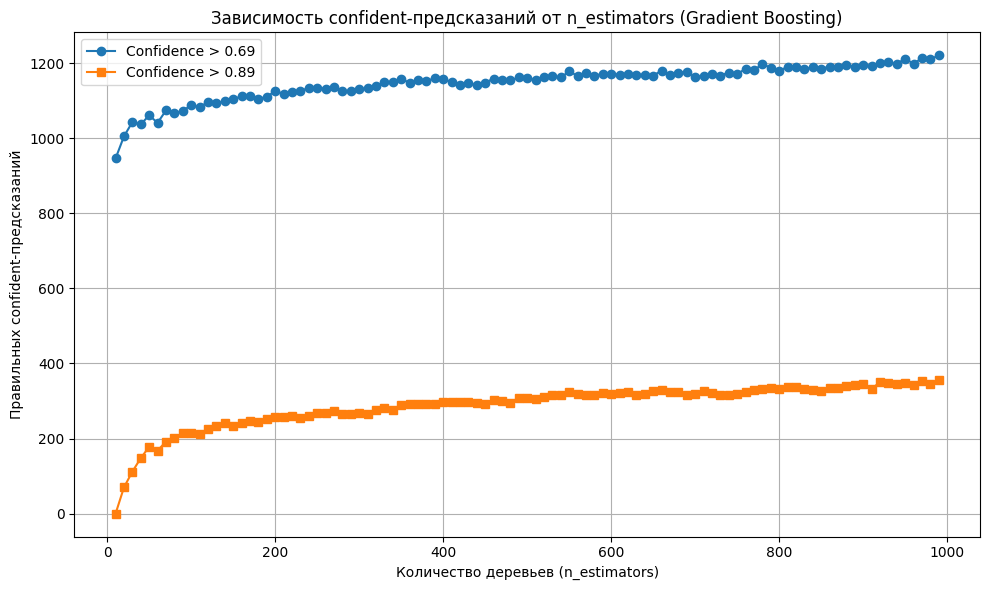

In [ ]:
#@title Gradient Boosting: warm start, max_depth=1, анализ confident-предсказаний
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

n_estimators_range = range(10, 1000, 10)
conf_thresh_69 = []
conf_thresh_89 = []

# Подготовка весов
weights_dict = {0: 2, 1: 3, 2: 3}
sample_weight = np.array([weights_dict[y] for y in train_target])

# Модель
gb = GradientBoostingClassifier(
    learning_rate = 0.35,
    subsample = 0.90,
    warm_start=True,
    max_depth=1,
    random_state=42
)

# Объединённый набор
X_full = np.vstack((val_input, test_input))
y_full = np.hstack((val_target.values, test_target.values))

# Цикл по количеству деревьев
for n in n_estimators_range:
    gb.set_params(n_estimators=n)
    gb.fit(train_input, train_target, sample_weight=sample_weight)

    probs = gb.predict_proba(X_full)
    preds = gb.predict(X_full)
    confs = probs.max(axis=1)
    correct = preds == y_full

    # Фильтрации по confidence
    mask_69 = confs > 0.69
    mask_89 = confs > 0.89

    conf_thresh_69.append(np.sum(correct[mask_69]))
    conf_thresh_89.append(np.sum(correct[mask_89]))

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, conf_thresh_69, label='Confidence > 0.69', marker='o')
plt.plot(n_estimators_range, conf_thresh_89, label='Confidence > 0.89', marker='s')
plt.xlabel('Количество деревьев (n_estimators)')
plt.ylabel('Правильных confident-предсказаний')
plt.title('Зависимость confident-предсказаний от n_estimators (Gradient Boosting)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [1]:
#@title Gradient Boosting: warm start, max_depth=1, анализ confident-предсказаний
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

n_estimators_range = range(10, 1000, 10)
conf_thresh_69 = []
conf_thresh_89 = []

# Подготовка весов
weights_dict = {0: 2, 1: 3, 2: 3}
sample_weight = np.array([weights_dict[y] for y in train_target])

# Модель
gb = GradientBoostingClassifier(
    learning_rate = 0.35,
    subsample = 0.95,
    warm_start=True,
    max_depth=1,
    random_state=42
)

# Объединённый набор
X_full = np.vstack((val_input, test_input))
y_full = np.hstack((val_target.values, test_target.values))

# Цикл по количеству деревьев
for n in n_estimators_range:
    gb.set_params(n_estimators=n)
    gb.fit(train_input, train_target, sample_weight=sample_weight)

    probs = gb.predict_proba(X_full)
    preds = gb.predict(X_full)
    confs = probs.max(axis=1)
    correct = preds == y_full

    # Фильтрации по confidence
    mask_69 = confs > 0.69
    mask_89 = confs > 0.89

    conf_thresh_69.append(np.sum(correct[mask_69]))
    conf_thresh_89.append(np.sum(correct[mask_89]))

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, conf_thresh_69, label='Confidence > 0.69', marker='o')
plt.plot(n_estimators_range, conf_thresh_89, label='Confidence > 0.89', marker='s')
plt.xlabel('Количество деревьев (n_estimators)')
plt.ylabel('Правильных confident-предсказаний')
plt.title('Зависимость confident-предсказаний от n_estimators (Gradient Boosting)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'train_target' is not defined